In [17]:
! pip install --only-binary :all: umap-learn

  Using cached umap_learn-0.5.11-py3-none-any.whl.metadata (26 kB)
  Using cached pynndescent-0.6.0-py3-none-any.whl.metadata (6.9 kB)
  Using cached tqdm-4.67.1-py3-none-any.whl.metadata (57 kB)
Using cached umap_learn-0.5.11-py3-none-any.whl (90 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.7/2.7 MB 16.1 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.0/43.0 MB 6.4 MB/s  0:00:06m0:00:0100:01
Using cached pynndescent-0.6.0-py3-none-any.whl (73 kB)
Using cached tqdm-4.67.1-py3-none-any.whl (78 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5/5 [umap-learn]5 [umap-learn]


In [30]:
! pip install --upgrade pip
! pip install pandas
! pip install scikit-learn
! pip install hdbscan 
! pip install matplotlib
! pip install --only-binary :all: umap-learn
! pip install seaborn

  Using cached seaborn-0.13.2-py3-none-any.whl.metadata (5.4 kB)
Using cached seaborn-0.13.2-py3-none-any.whl (294 kB)


# Imports

In [43]:
import re
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import HDBSCAN
from sklearn.metrics import silhouette_score, davies_bouldin_score

from scipy.sparse import hstack, csr_matrix


# Load + Data Cleanup

In [44]:
columns = [
    "Log Source and Client IP",
    "Identd identity",
    "Authenticated User",
    "Timestamp",
    "HTTP Request Line",
    "HTTP Status Code",
    "Response size (bytes)",
    "Referer Header",
    "User-Agent"
]

data = pd.read_csv("honeypot_logs.csv", names=columns, header=None)

# Extract IP (your format looks like "...:IP")
data["client_ip"] = data["Log Source and Client IP"].astype(str).str.split(":").str[-1]

# Timestamp cleanup (adjust format if your logs include timezone like +0000)
data["Timestamp"] = data["Timestamp"].astype(str).str.strip("[] ")
data["Timestamp"] = pd.to_datetime(
    data["Timestamp"],
    format="%d/%b/%Y:%H:%M:%S",  # change to "%d/%b/%Y:%H:%M:%S %z" if timezone exists
    errors="coerce"
)

# If no timezone in raw logs, localize as UTC
data["Timestamp"] = data["Timestamp"].dt.tz_localize("UTC", nonexistent="shift_forward", ambiguous="NaT")

# Types
data["HTTP Status Code"] = pd.to_numeric(data["HTTP Status Code"], errors="coerce")
data["Response size (bytes)"] = pd.to_numeric(data["Response size (bytes)"], errors="coerce").fillna(0)


# parse request line into method + path 

In [45]:
req_re = re.compile(r"^(?P<method>[A-Z]+)\s+(?P<path>\S+)\s+HTTP\/")

def parse_request(line: str):
    line = str(line)
    m = req_re.search(line)
    if not m:
        return ("UNK", "/")
    method = m.group("method")
    path = m.group("path")
    path = path.split("?")[0]                      # drop querystring
    path = re.sub(r"\d+", "0", path)               # normalize digits
    return (method, path)

data[["http_method", "http_path"]] = data["HTTP Request Line"].apply(
    lambda x: pd.Series(parse_request(x))
)

data["time_window"] = data["Timestamp"].dt.floor("1min")
data = data.sort_values("Timestamp")


# Break Requests down into sessions

In [46]:
grouped = (
    data.groupby(["client_ip", "time_window"])
    .agg(
        request_count=("HTTP Request Line", "count"),
        unique_paths=("http_path", "nunique"),
        unique_methods=("http_method", "nunique"),
        status_2xx=("HTTP Status Code", lambda x: ((x >= 200) & (x < 300)).sum()),
        status_3xx=("HTTP Status Code", lambda x: ((x >= 300) & (x < 400)).sum()),
        status_4xx=("HTTP Status Code", lambda x: ((x >= 400) & (x < 500)).sum()),
        status_5xx=("HTTP Status Code", lambda x: ((x >= 500) & (x < 600)).sum()),
        status_401=("HTTP Status Code", lambda x: (x == 401).sum()),
        status_403=("HTTP Status Code", lambda x: (x == 403).sum()),
        status_404=("HTTP Status Code", lambda x: (x == 404).sum()),
        status_429=("HTTP Status Code", lambda x: (x == 429).sum()),
        avg_response_size=("Response size (bytes)", "mean"),
        std_response_size=("Response size (bytes)", "std"),
        paths=("http_path", list),
        methods=("http_method", list),
        uas=("User-Agent", list),
    )
    .reset_index()
)

grouped["std_response_size"] = grouped["std_response_size"].fillna(0)

# Ratios help a lot
grouped["ratio_4xx"] = grouped["status_4xx"] / grouped["request_count"].clip(lower=1)
grouped["ratio_429"] = grouped["status_429"] / grouped["request_count"].clip(lower=1)

grouped.head()


,client_ip,time_window,request_count,unique_paths,unique_methods,status_2xx,status_3xx,status_4xx,status_5xx,status_401,status_403,status_404,status_429,avg_response_size,std_response_size,paths,methods,uas,ratio_4xx,ratio_429
0,101.36.107.228,2025-12-19 09:17:00+00:00,37,37,1,36,0,1,0,0,0,1,0,1667.054054,249.064466,[/vendor/phpunit/phpunit/src/Util/PHP/eval-std...,"[GET, GET, GET, GET, GET, GET, GET, GET, GET, ...","[libredtail-http, libredtail-http, libredtail-...",0.027027,0.0
1,103.147.45.70,2025-12-17 04:25:00+00:00,1,1,1,0,1,0,0,0,0,0,0,178.000000,0.000000,[/api/check_version],[GET],[Mozilla/5.0 (Windows NT 10.0; Win64; x64) App...,0.000000,0.0
2,103.168.91.103,2025-12-15 00:41:00+00:00,3,3,1,3,0,0,0,0,0,0,0,1708.000000,0.000000,[/vendor/phpunit/phpunit/src/Util/PHP/eval-std...,"[GET, GET, GET]","[libredtail-http, libredtail-http, libredtail-...",0.000000,0.0
3,103.168.91.103,2025-12-15 00:42:00+00:00,34,34,1,33,0,1,0,0,0,1,0,1663.441176,259.820356,[/vendor/phpunit/phpunit/LICENSE/eval-stdin.ph...,"[GET, GET, GET, GET, GET, GET, GET, GET, GET, ...","[libredtail-http, libredtail-http, libredtail-...",0.029412,0.0
4,103.207.99.1,2025-12-14 12:52:00+00:00,8,8,1,8,0,0,0,0,0,0,0,1708.000000,0.000000,[/vendor/phpunit/phpunit/src/Util/PHP/eval-std...,"[GET, GET, GET, GET, GET, GET, GET, GET]","[libredtail-http, libredtail-http, libredtail-...",0.000000,0.0


# Train - Test Data Split

In [47]:
train_data, test_data = train_test_split(grouped, test_size=0.3, random_state=42)


# Feature Pre-processing (Scaling and Vectorisation)

In [48]:
num_cols = [
    "request_count", "unique_paths", "unique_methods",
    "status_401", "status_403", "status_404", "status_429",
    "avg_response_size", "std_response_size",
    "ratio_4xx", "ratio_429",
]

scaler = StandardScaler()
X_num_train = scaler.fit_transform(train_data[num_cols].fillna(0))
X_num_test  = scaler.transform(test_data[num_cols].fillna(0))

# TF-IDF on PATHS, not full request lines
train_data["path_text"] = train_data["paths"].apply(lambda xs: " ".join(xs))
test_data["path_text"]  = test_data["paths"].apply(lambda xs: " ".join(xs))

vectorizer = TfidfVectorizer(
    max_features=500,
    ngram_range=(1, 2),
    token_pattern=r"[^\/\s]+",   # split on /
    min_df=2
)

X_txt_train = vectorizer.fit_transform(train_data["path_text"])
X_txt_test  = vectorizer.transform(test_data["path_text"])

X_train = hstack([X_txt_train, csr_matrix(X_num_train)])
X_test  = hstack([X_txt_test,  csr_matrix(X_num_test)])

X_train.shape, X_test.shape


((431, 511), (186, 511))

# Pick best K based off silhoette score

In [62]:
import numpy as np
import pandas as pd
from hdbscan import HDBSCAN
from sklearn.metrics import silhouette_score, davies_bouldin_score

# ---- search space (tune ranges to your traffic volume) ----
MCS = [10, 20, 30, 50, 80, 120, 200]
MS  = [None, 5, 10, 20]

rows = []

for mcs in MCS:
    for ms in MS:
        hdb = HDBSCAN(
            min_cluster_size=mcs,
            min_samples=ms,
            # If X_train is TF-IDF / sparse text, cosine is usually a better default than euclidean.
            # If X_train is dense numeric, keep euclidean.
            metric="cosine" if hasattr(X_train, "tocsr") or "scipy.sparse" in str(type(X_train)) else "euclidean"
        )

        labels = hdb.fit_predict(X_train)

        mask = labels != -1
        n_points = len(labels)
        n_noise = int((~mask).sum())
        noise_ratio = n_noise / n_points

        # clusters excluding noise
        n_clusters = len(set(labels[mask])) if mask.any() else 0

        # HDBSCAN stability (higher = more stable clusters)
        # cluster_persistence_ exists after fit; empty when no clusters
        stability_mean = float(np.mean(hdb.cluster_persistence_)) if n_clusters > 0 else 0.0

        sil = np.nan
        db = np.nan

        # Score only on non-noise points, and only if >=2 clusters
        if mask.sum() > 1 and n_clusters >= 2:
            X_eval = X_train[mask]
            y_eval = labels[mask]

            # silhouette supports sparse input (OK)
            sil = float(silhouette_score(X_eval, y_eval))

            # Davies-Bouldin needs dense; fall back carefully
            if hasattr(X_eval, "toarray") and X_eval.shape[1] < 2000:
                X_dense = X_eval.toarray()
            else:
                # If you have a dense numeric representation for high-dim sparse text,
                # use it here. Otherwise, skip DB.
                X_dense = X_num_train[mask] if "X_num_train" in globals() else None

            if X_dense is not None:
                db = float(davies_bouldin_score(X_dense, y_eval))

        rows.append({
            "min_cluster_size": mcs,
            "min_samples": ms,
            "n_clusters": int(n_clusters),
            "noise_ratio": float(noise_ratio),
            "silhouette": sil,
            "davies_bouldin": db,
            "stability_mean": stability_mean,
        })

results = pd.DataFrame(rows)

# ---- pick "best" config with an analyst-friendly objective ----
# We want:
# - stable clusters (maximize stability_mean)
# - not too many clusters (target range)
# - not all noise
# - silhouette helps but isn't the main boss
TARGET_CLUSTERS = 20

def objective(r):
    # penalties
    cluster_penalty = abs(r["n_clusters"] - TARGET_CLUSTERS)
    noise_penalty = 0 if (0.2 <= r["noise_ratio"] <= 0.9) else 5  # keep in a plausible range
    sil_bonus = 0 if np.isnan(r["silhouette"]) else -0.5 * r["silhouette"]  # higher sil => lower objective
    # main term: prefer higher stability
    return (-2.0 * r["stability_mean"]) + cluster_penalty + noise_penalty + sil_bonus

results["objective"] = results.apply(objective, axis=1)
best = results.sort_values("objective").iloc[0]

print("Best config:")
print(best.to_string())

# Optional: show the whole table sorted
results.sort_values(["objective", "stability_mean"], ascending=[True, False])


Best config:
min_cluster_size    10.000000
min_samples          5.000000
n_clusters          14.000000
noise_ratio          0.213457
silhouette           0.365729
davies_bouldin       1.445903
stability_mean       1.000000
objective            3.817136


,min_cluster_size,min_samples,n_clusters,noise_ratio,silhouette,davies_bouldin,stability_mean,objective
1,10,5.0,14,0.213457,0.365729,1.445903,1.000000,3.817136
0,10,NaN,12,0.438515,0.507689,1.096578,1.000000,5.746156
2,10,10.0,12,0.438515,0.507689,1.096578,1.000000,5.746156
5,20,5.0,8,0.213457,0.365175,1.043176,1.000000,9.817413
3,10,20.0,7,0.470998,0.259912,2.257847,1.000000,10.870044
4,20,NaN,5,0.529002,0.302572,1.651858,1.000000,12.848714
7,20,20.0,5,0.529002,0.302572,1.651858,1.000000,12.848714
6,20,10.0,4,0.378190,0.253872,1.174162,1.000000,13.873064
10,30,10.0,3,0.310905,0.217578,1.306885,0.298828,16.293556
11,30,20.0,3,0.535963,0.210542,1.167931,0.266021,16.362687


# Fit Model

In [115]:
from hdbscan import HDBSCAN

# If you ran the previous cell, you already have:
# - results (DataFrame)
# - best (Series with min_cluster_size + min_samples)

best_mcs = int(best["min_cluster_size"])
best_ms  = None if pd.isna(best["min_samples"]) else int(best["min_samples"])

# Match the metric choice you used in the sweep
best_metric = "cosine" if hasattr(X_train, "tocsr") or "scipy.sparse" in str(type(X_train)) else "euclidean"

hdb = HDBSCAN(
    min_cluster_size=best_mcs,
    min_samples=best_ms,
    metric=best_metric,
    prediction_data=True
)

train_data["cluster"] = hdb.fit_predict(X_train)

# Cluster counts (includes -1 noise at the top)
train_data["cluster"].value_counts().sort_index()


cluster
-1     92
 0     37
 1     19
 2     18
 3     32
 4     14
 5     17
 6     37
 7     35
 8     21
 9     22
 10    15
 11    25
 12    20
 13    27
Name: count, dtype: int64

In [100]:
vc = train_data["cluster"].value_counts()
out = pd.DataFrame({
    "count": vc,
    "pct": (vc / vc.sum()).round(4)
}).sort_index()

print("Noise (-1):", int(out.loc[-1, "count"]) if -1 in out.index else 0)
out


Noise (-1): 92


,count,pct
cluster,,
-1,92,0.2135
0,37,0.0858
1,19,0.0441
2,18,0.0418
3,32,0.0742
4,14,0.0325
5,17,0.0394
6,37,0.0858
7,35,0.0812


# Interpret Clusters

In [101]:
for c in sorted(train_data["cluster"].unique()):
    subset = train_data[train_data["cluster"] == c]
    # flatten paths
    paths = pd.Series([p for ps in subset["paths"] for p in ps])
    print(f"\nCluster {c} | n={len(subset)}")
    print("Top paths:")
    print(paths.value_counts().head(10))
    print("Avg request_count:", subset["request_count"].mean())
    print("Avg ratio_4xx:", subset["ratio_4xx"].mean())



Cluster -1 | n=92
Top paths:
/wp-login.php                               12
/wp-admin/js/autoload_classmap.php          10
/apis/.env.production                        8
/login                                       7
/.well-known/acme-challenge/wp-login.php     7
/apis/.env.staging                           6
/wp-includes/html-api/index.php              6
/wp-admin/autoload_classmap.php              6
/wp-includes/rest-api/fields/                5
/wp-admin/index.php                          5
Name: count, dtype: int64
Avg request_count: 5.467391304347826
Avg ratio_4xx: 0.04649938175753393

Cluster 0 | n=37
Top paths:
/                                                      13
/api/.env                                               9
/vendor/phpunit/phpunit/src/Util/PHP/eval-stdin.php     5
/login                                                  4
/api/sonicos/is-sslvpn-enabled                          4
/api/src/.env                                           4
/api/index.php/v0/config/

In [66]:
import umap.umap_ as umap
import matplotlib.pyplot as plt

# X_train is the hstacked TF-IDF + numeric
X_dense = X_train.toarray() if hasattr(X_train, "toarray") else X_train

reducer = umap.UMAP(
    n_components=2,
    random_state=42,
    metric="cosine"
)

embedding = reducer.fit_transform(X_dense)

train_data["umap_x"] = embedding[:, 0]
train_data["umap_y"] = embedding[:, 1]


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


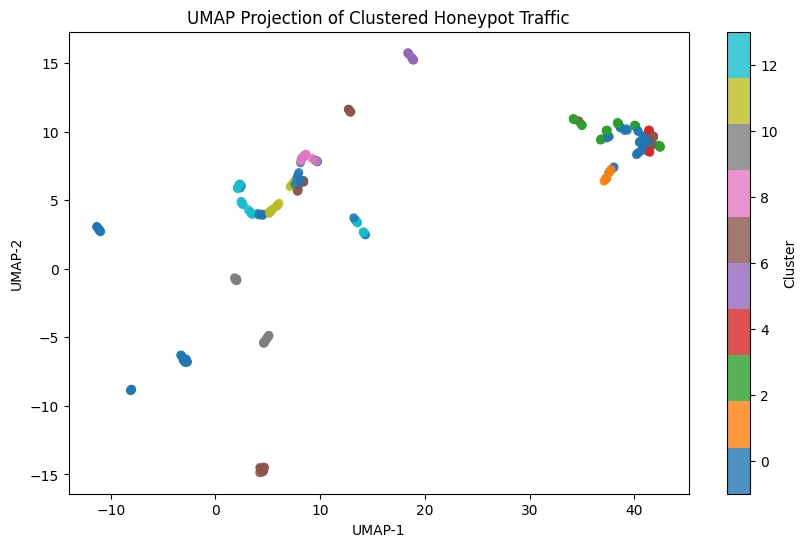

In [102]:
plt.figure(figsize=(10, 6))
scatter = plt.scatter(
    train_data["umap_x"],
    train_data["umap_y"],
    c=train_data["cluster"],
    cmap="tab10",
    s=30,
    alpha=0.8
)

plt.title("UMAP Projection of Clustered Honeypot Traffic")
plt.xlabel("UMAP-1")
plt.ylabel("UMAP-2")
plt.colorbar(scatter, label="Cluster")
plt.show()



In [103]:
from sklearn.preprocessing import normalize

endpoint_counts = (
    train_data.explode("paths")
    .groupby(["cluster", "paths"])
    .size()
    .unstack(fill_value=0)
)

# Optional: only show top 20 paths
top_paths = endpoint_counts.sum().sort_values(ascending=False).head(20).index
heatmap_data = endpoint_counts[top_paths]


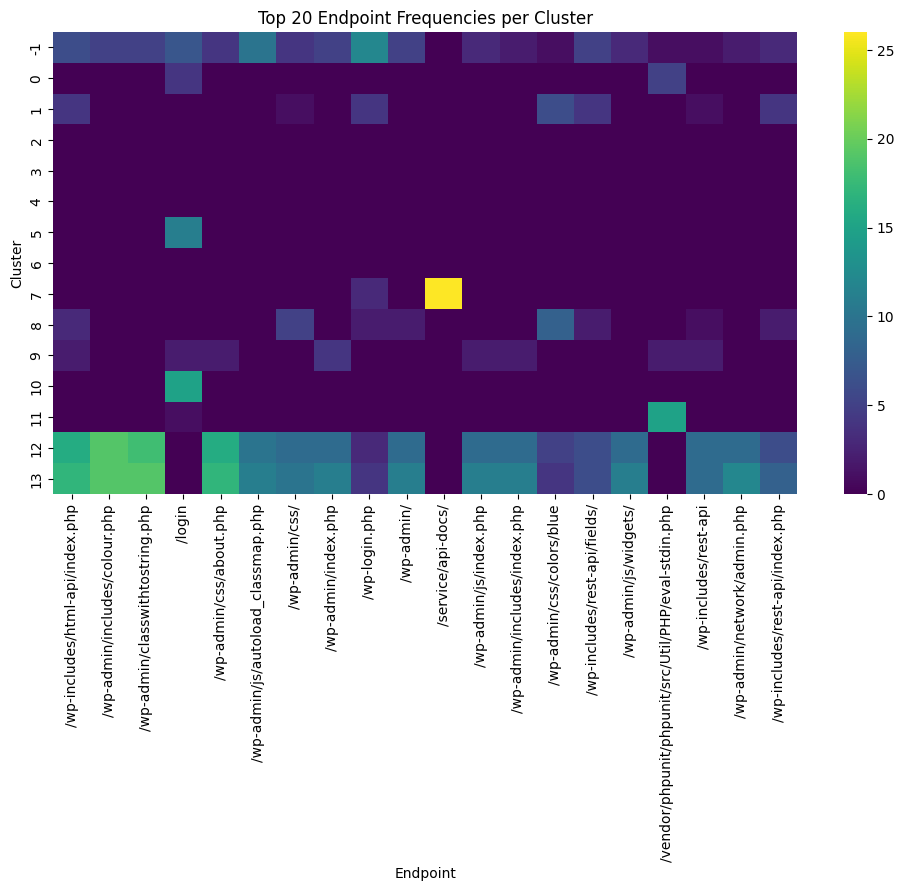

In [104]:
import seaborn as sns
plt.figure(figsize=(12, 6))
sns.heatmap(heatmap_data, cmap="viridis")
plt.title("Top 20 Endpoint Frequencies per Cluster")
plt.xlabel("Endpoint")
plt.ylabel("Cluster")
plt.show()


# Labelling Clusters

In [105]:
LABEL_RULES = [
    {
        "label": "WordPress exploitation / admin enumeration",
        "patterns": [
            r"^/wp-admin\b", r"^/wp-login\.php$", r"^/wp-includes\b",
            r"autoload_classmap\.php", r"classwithtostring\.php", r"wp-conflg\.php",
            r"xmlrpc\.php", r"wp-json", r"rest-api"
        ],
        "min_hits": 3
    },
    {
        "label": "PHPUnit RCE probing (eval-stdin.php)",
        "patterns": [r"phpunit", r"eval-stdin\.php"],
        "min_hits": 2
    },
    {
        "label": "Secrets discovery (.env harvesting)",
        "patterns": [r"\.env(\.|$)", r"/api/\.env", r"/apis/\.env", r"/nodeapi/\.env"],
        "min_hits": 2
    },
    {
        "label": "Swagger / OpenAPI docs enumeration",
        "patterns": [
            r"api-docs", r"swagger", r"openapi", r"/service/api-docs/?$",
            r"swagger\.json", r"api-docs/swagger\.json"
        ],
        "min_hits": 1
    },
    {
        "label": "Generic login discovery / credential targeting",
        "patterns": [
            r"/login(\.|/|$)", r"login\.jsp", r"login\.html", r"login\.htm",
            r"/remote/login", r"/manage/account/login", r"login\.action", r"nidp/app/login"
        ],
        "min_hits": 2
    },
    {
        "label": "IoT / embedded device admin login scan",
        "patterns": [
            r"boaform/admin/formLogin", r"cgi-bin/authLogin\.cgi", r"cgi-bin/login\.cgi",
            r"/ssi\.cgi/Login\.htm"
        ],
        "min_hits": 1
    },
    {
        "label": "SonicWall SSLVPN probe",
        "patterns": [r"/api/sonicos/is-sslvpn-enabled"],
        "min_hits": 1
    },
    {
        "label": "ACME challenge path abuse / odd probe",
        "patterns": [r"^/\.well-known/acme-challenge/.*wp-login\.php$"],
        "min_hits": 1
    },
    {
        "label": "PHP info/config discovery",
        "patterns": [
            r"phpinfo\.php", r"/v0/config/application",
            r"/config/application", r"/api/info\.php"
        ],
        "min_hits": 1
    },
]


# Helper functions (cluster summarization + scoring)

In [106]:
def cluster_top_paths_from_list(df, cluster_col="cluster", list_col="paths", topn=50):
    """
    For data where each row contains a list of paths (e.g., per client/time_window),
    explode into one path per row, then compute top paths per cluster.
    Returns dict: cluster -> list of (path, count)
    """
    tmp = df[[cluster_col, list_col]].copy()
    tmp = tmp.explode(list_col)
    tmp = tmp.dropna(subset=[list_col])

    # Ensure strings (sometimes paths can be non-str)
    tmp[list_col] = tmp[list_col].astype(str)

    out = {}
    for c, g in tmp.groupby(cluster_col):
        vc = g[list_col].value_counts().head(topn)
        out[c] = list(zip(vc.index.tolist(), vc.values.tolist()))
    return out

tops = cluster_top_paths_from_list(train_data, cluster_col="cluster", list_col="paths", topn=50)
list(tops.items())[:1]  # peek

def _flatten_to_strings(x):
    """Return a flat list of strings from x (string, list, nested list, etc.)."""
    if x is None:
        return []
    if isinstance(x, (str, bytes)):
        return [x.decode() if isinstance(x, bytes) else x]
    if isinstance(x, (list, tuple, set)):
        out = []
        for item in x:
            out.extend(_flatten_to_strings(item))
        return out
    # fallback: coerce to string
    return [str(x)]

def score_cluster(paths_counts, rule):
    """
    Score a cluster against a rule.

    paths_counts: list of (path_or_paths, count)
      where path_or_paths may be a str OR a list/nested list of str.
    """
    patterns = [re.compile(p, flags=re.I) for p in rule["patterns"]]
    hits = 0
    matched_patterns = set()
    matched_paths = 0

    for path_obj, cnt in paths_counts:
        # Convert path_obj into one or more strings
        path_list = _flatten_to_strings(path_obj)

        # If any of the strings match any pattern, count it once for this (path_obj, cnt)
        matched_this_item = False
        for path in path_list:
            for pat in patterns:
                if pat.search(path):
                    hits += cnt
                    matched_patterns.add(pat.pattern)
                    matched_paths += 1
                    matched_this_item = True
                    break
            if matched_this_item:
                break

    return hits, sorted(matched_patterns), matched_paths


def label_cluster_multitag(paths_counts, top_k=3, min_secondary_score=0.35):
    """
    Return primary label + a few secondary tags.
    min_secondary_score is relative to best score (0-1).
    """
    candidates = []
    total = sum(cnt for _, cnt in paths_counts) + 1e-9

    for rule in LABEL_RULES:
        hits, matched_patterns, matched_paths = score_cluster(paths_counts, rule)
        if hits <= 0:
            continue

        coverage = hits / total
        meets_min = hits >= rule["min_hits"]
        score = (1 if meets_min else 0) * 10 + coverage * 5 + matched_paths * 0.1

        candidates.append({
            "label": rule["label"],
            "score": score,
            "coverage": coverage,
            "hits": hits,
            "patterns": matched_patterns
        })

    if not candidates:
        return {
            "primary_label": "Uncategorized / miscellaneous scanning",
            "label_conf": 0.0,
            "matched_patterns": "",
            "secondary_labels": ""
        }

    candidates = sorted(candidates, key=lambda x: x["score"], reverse=True)
    best = candidates[0]
    best_score = best["score"]

    # confidence same as before
    conf = min(1.0, best["coverage"] + (0.15 if best["hits"] >= 10 else 0.0))

    # Secondary tags: other labels close-ish to best
    secondary = []
    for c in candidates[1:]:
        rel = c["score"] / (best_score + 1e-9)
        if rel >= min_secondary_score:
            secondary.append(c["label"])
        if len(secondary) >= (top_k - 1):
            break

    return {
        "primary_label": best["label"],
        "label_conf": round(conf, 3),
        "matched_patterns": ", ".join(best["patterns"]),
        "secondary_labels": "; ".join(secondary)
    }


# Generate labels for all clusters

In [88]:
type(train_data.loc[0, "paths"]), train_data.loc[0, "paths"]



(list,
 ['/vendor/phpunit/phpunit/src/Util/PHP/eval-stdin.php',
  '/vendor/phpunit/phpunit/Util/PHP/eval-stdin.php',
  '/vendor/phpunit/src/Util/PHP/eval-stdin.php',
  '/vendor/phpunit/Util/PHP/eval-stdin.php',
  '/vendor/phpunit/phpunit/LICENSE/eval-stdin.php',
  '/vendor/vendor/phpunit/phpunit/src/Util/PHP/eval-stdin.php',
  '/phpunit/phpunit/src/Util/PHP/eval-stdin.php',
  '/phpunit/src/Util/PHP/eval-stdin.php',
  '/phpunit/phpunit/Util/PHP/eval-stdin.php',
  '/lib/phpunit/phpunit/src/Util/PHP/eval-stdin.php',
  '/phpunit/Util/PHP/eval-stdin.php',
  '/lib/phpunit/src/Util/PHP/eval-stdin.php',
  '/lib/phpunit/phpunit/Util/PHP/eval-stdin.php',
  '/lib/vendor/phpunit/phpunit/src/Util/PHP/eval-stdin.php',
  '/lib/phpunit/Util/PHP/eval-stdin.php',
  '/www/vendor/phpunit/phpunit/src/Util/PHP/eval-stdin.php',
  '/laravel/vendor/phpunit/phpunit/src/Util/PHP/eval-stdin.php',
  '/ws/vendor/phpunit/phpunit/src/Util/PHP/eval-stdin.php',
  '/yii/vendor/phpunit/phpunit/src/Util/PHP/eval-stdin.php

In [107]:
# Get top paths for each cluster
tops = cluster_top_paths(train_data, cluster_col="cluster", path_col="paths", topn=50)

# Apply auto-labeling
labels = []
for c, paths_counts in tops.items():
    res = label_cluster_multitag(paths_counts)
    labels.append({
        "cluster": c,
        "cluster_label": res["primary_label"],
        "label_conf": res["label_conf"],
        "matched_patterns": res["matched_patterns"],
        "secondary_labels": res["secondary_labels"],
    })

cluster_labels = pd.DataFrame(labels).sort_values("cluster")
cluster_labels



,cluster,cluster_label,label_conf,matched_patterns,secondary_labels
0,-1,WordPress exploitation / admin enumeration,0.630,"^/wp-admin\b, ^/wp-includes\b, ^/wp-login\.php...",Generic login discovery / credential targeting...
1,0,Secrets discovery (.env harvesting),0.474,\.env(\.|$),Generic login discovery / credential targeting...
2,1,WordPress exploitation / admin enumeration,1.000,"^/wp-admin\b, ^/wp-includes\b",
3,2,IoT / embedded device admin login scan,0.761,boaform/admin/formLogin,Secrets discovery (.env harvesting); PHP info/...
4,3,Secrets discovery (.env harvesting),0.962,\.env(\.|$),PHP info/config discovery
5,4,Generic login discovery / credential targeting,0.500,/login(\.|/|$),Secrets discovery (.env harvesting)
6,5,Generic login discovery / credential targeting,1.000,/login(\.|/|$),
7,6,Generic login discovery / credential targeting,1.000,/login(\.|/|$),IoT / embedded device admin login scan; Secret...
8,7,Swagger / OpenAPI docs enumeration,0.893,api-docs,Generic login discovery / credential targeting...
9,8,WordPress exploitation / admin enumeration,1.000,"^/wp-admin\b, ^/wp-includes\b",


In [108]:
# Can be modified based on your org's risk model

SEVERITY = {
    "PHPUnit RCE probing (eval-stdin.php)": "High",
    "Secrets discovery (.env harvesting)": "High",
    "WordPress exploitation / admin enumeration": "Medium-High",
    "Swagger / OpenAPI docs enumeration": "Medium",
    "IoT / embedded device admin login scan": "Medium",
    "Generic login discovery / credential targeting": "Low-Medium",
    "Uncategorized / miscellaneous scanning": "Low",
}

cluster_labels["severity"] = cluster_labels["cluster_label"].map(SEVERITY).fillna("Low")
cluster_labels.sort_values(["severity", "label_conf"], ascending=[True, False])


,cluster,cluster_label,label_conf,matched_patterns,secondary_labels,severity
12,11,PHPUnit RCE probing (eval-stdin.php),1.000,phpunit,Generic login discovery / credential targeting,High
4,3,Secrets discovery (.env harvesting),0.962,\.env(\.|$),PHP info/config discovery,High
1,0,Secrets discovery (.env harvesting),0.474,\.env(\.|$),Generic login discovery / credential targeting...,High
6,5,Generic login discovery / credential targeting,1.000,/login(\.|/|$),,Low-Medium
7,6,Generic login discovery / credential targeting,1.000,/login(\.|/|$),IoT / embedded device admin login scan; Secret...,Low-Medium
11,10,Generic login discovery / credential targeting,1.000,/login(\.|/|$),,Low-Medium
5,4,Generic login discovery / credential targeting,0.500,/login(\.|/|$),Secrets discovery (.env harvesting),Low-Medium
8,7,Swagger / OpenAPI docs enumeration,0.893,api-docs,Generic login discovery / credential targeting...,Medium
3,2,IoT / embedded device admin login scan,0.761,boaform/admin/formLogin,Secrets discovery (.env harvesting); PHP info/...,Medium
2,1,WordPress exploitation / admin enumeration,1.000,"^/wp-admin\b, ^/wp-includes\b",,Medium-High


In [109]:
train_data = train_data.merge(
    cluster_labels[["cluster", "cluster_label", "label_conf", "secondary_labels"]],
    on="cluster",
    how="left"
)

train_data.head()

,client_ip,time_window,request_count,unique_paths,unique_methods,status_2xx,status_3xx,status_4xx,status_5xx,status_401,...,umap_x,umap_y,cluster_label_x,label_conf_x,cluster_label_y,label_conf_y,secondary_labels_x,cluster_label,label_conf,secondary_labels_y
0,185.234.69.214,2025-12-25 03:21:00+00:00,1,1,1,0,0,1,0,0,...,-11.056076,2.796431,.env Secret Harvester,1.0,Secrets discovery (.env harvesting),0.474,Generic login discovery / credential targeting...,Secrets discovery (.env harvesting),0.474,Generic login discovery / credential targeting...
1,206.168.34.54,2025-12-22 04:53:00+00:00,1,1,1,0,0,1,0,0,...,-2.698736,-6.758484,Credential Stuffing / Login Probe,1.0,Secrets discovery (.env harvesting),0.474,Generic login discovery / credential targeting...,Secrets discovery (.env harvesting),0.474,Generic login discovery / credential targeting...
2,122.96.31.44,2025-12-20 11:04:00+00:00,1,1,1,0,1,0,0,0,...,42.439625,8.911422,Credential Stuffing / Login Probe,1.0,IoT / embedded device admin login scan,0.761,Secrets discovery (.env harvesting); PHP info/...,IoT / embedded device admin login scan,0.761,Secrets discovery (.env harvesting); PHP info/...
3,101.36.107.228,2025-12-19 09:17:00+00:00,37,37,1,36,0,1,0,0,...,5.155041,4.126251,PHPUnit RCE Scanner,1.0,PHPUnit RCE probing (eval-stdin.php),1.000,Generic login discovery / credential targeting,PHPUnit RCE probing (eval-stdin.php),1.000,Generic login discovery / credential targeting
4,86.48.30.152,2025-12-22 06:13:00+00:00,13,13,1,12,0,1,0,0,...,5.480060,4.365679,PHPUnit RCE Scanner,1.0,PHPUnit RCE probing (eval-stdin.php),1.000,Generic login discovery / credential targeting,PHPUnit RCE probing (eval-stdin.php),1.000,Generic login discovery / credential targeting


# Test Accuracy with test data set

In [118]:
# Make X_test dense the same way you did for X_train
X_test_dense = X_test.toarray() if hasattr(X_test, "toarray") else X_test

# Transform test into the SAME UMAP space
test_embedding = reducer.transform(X_test_dense)

test_data["umap_x"] = test_embedding[:, 0]
test_data["umap_y"] = test_embedding[:, 1]

test_data[["umap_x", "umap_y"]].head()



,umap_x,umap_y
49,4.107682,-14.868504
581,5.174486,4.051898
82,4.107682,-14.868504
304,40.319080,9.171913
109,14.178137,2.636303


In [119]:
import numpy as np
from sklearn.metrics import pairwise_distances

# Centroids of TRAIN clusters in UMAP space (exclude noise)
train_centroids = (
    train_data[train_data["cluster"] != -1]
    .groupby("cluster")[["umap_x", "umap_y"]]
    .mean()
)

# Matrix of centroids
C = train_centroids[["umap_x", "umap_y"]].values
cluster_ids = train_centroids.index.values

# Distances from each test point to each centroid
Xt = test_data[["umap_x", "umap_y"]].values
D = pairwise_distances(Xt, C)

# nearest centroid index
nearest_idx = D.argmin(axis=1)

test_data["cluster_pred"] = cluster_ids[nearest_idx]
test_data["cluster_pred_dist"] = D.min(axis=1)   # smaller = more confident

test_data[["cluster_pred", "cluster_pred_dist"]].head()



,cluster_pred,cluster_pred_dist
49,7,5.655680
581,11,1.109373
82,7,5.655680
304,4,1.086424
109,12,0.532211


In [120]:
train_centroid = train_data.groupby("cluster")[["umap_x", "umap_y"]].mean()
test_centroid  = test_data.groupby("cluster_pred")[["umap_x", "umap_y"]].mean()

common = train_centroid.index.intersection(test_centroid.index)

drift = (train_centroid.loc[common] - test_centroid.loc[common]).abs()
drift["drift_score"] = np.sqrt(drift["umap_x"]**2 + drift["umap_y"]**2)

drift.sort_values("drift_score", ascending=False).head(20)


,umap_x,umap_y,drift_score
7,1.280255,5.508870,5.655679
0,0.287107,3.211450,3.224258
9,0.097316,1.249210,1.252995
2,0.698700,0.083014,0.703614
4,0.617897,0.115074,0.628521
1,0.434124,0.395040,0.586958
8,0.091081,0.564826,0.572122
3,0.537624,0.028286,0.538368
11,0.365623,0.255234,0.445898
5,0.137323,0.134593,0.192284


In [122]:
# Display cluster labels table
cluster_labels

,cluster,cluster_label,label_conf,matched_patterns,secondary_labels,severity
0,-1,WordPress exploitation / admin enumeration,0.630,"^/wp-admin\b, ^/wp-includes\b, ^/wp-login\.php...",Generic login discovery / credential targeting...,Medium-High
1,0,Secrets discovery (.env harvesting),0.474,\.env(\.|$),Generic login discovery / credential targeting...,High
2,1,WordPress exploitation / admin enumeration,1.000,"^/wp-admin\b, ^/wp-includes\b",,Medium-High
3,2,IoT / embedded device admin login scan,0.761,boaform/admin/formLogin,Secrets discovery (.env harvesting); PHP info/...,Medium
4,3,Secrets discovery (.env harvesting),0.962,\.env(\.|$),PHP info/config discovery,High
5,4,Generic login discovery / credential targeting,0.500,/login(\.|/|$),Secrets discovery (.env harvesting),Low-Medium
6,5,Generic login discovery / credential targeting,1.000,/login(\.|/|$),,Low-Medium
7,6,Generic login discovery / credential targeting,1.000,/login(\.|/|$),IoT / embedded device admin login scan; Secret...,Low-Medium
8,7,Swagger / OpenAPI docs enumeration,0.893,api-docs,Generic login discovery / credential targeting...,Medium
9,8,WordPress exploitation / admin enumeration,1.000,"^/wp-admin\b, ^/wp-includes\b",,Medium-High


In [121]:
# Map cluster -> label from train
cluster_to_label = (
    train_data[["cluster", "cluster_label"]]
    .drop_duplicates()
    .set_index("cluster")["cluster_label"]
    .to_dict()
)

test_data["pred_label"] = test_data["cluster_pred"].map(cluster_to_label).fillna("Unknown / New")

test_data["pred_label"].value_counts()


pred_label
WordPress exploitation / admin enumeration        75
Secrets discovery (.env harvesting)               45
Generic login discovery / credential targeting    31
Swagger / OpenAPI docs enumeration                19
PHPUnit RCE probing (eval-stdin.php)              12
IoT / embedded device admin login scan             4
Name: count, dtype: int64